In [3]:
# pytorchでmnist
# https://book.mynavi.jp/manatee/detail/id=89498

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,data_home=".") # data_homeは保存先

# pytorchによるディープラーニングの手順------------
# 1.データの前処理
# 2.DataLoderの作成
# 3.ネットワークの構築
# 4.誤差関数（目的関数，損失関数）と最適化手法の設定
# 5.学習と推論の設定
# 6.学習と推論の実行
#---------------------------------------------



この画像データのラベルは5です


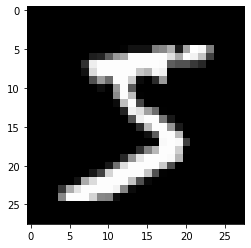

In [4]:
# データの前処理
X = mnist.data/255 # 正規化
y = mnist.target

y = np.array(y)
y = y.astype(np.int32)

# 可視化
plt.imshow(X[0].reshape(28,28),cmap="gray")
print("この画像データのラベルは{:.0f}です".format(y[0]))

In [5]:
# 2.DataLoaderの作成
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# 2.1 データを訓練データとテストデータに分割(6:1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/7,random_state=0)

# 2.2 データをpytorchのTensorに変換, NumpyデータをPytorchで扱える型の変数に変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train) # ラベルのような整数データの場合はtorch.LongTensorを使用します
y_test = torch.LongTensor(y_test)

# 2.3 データとラベルをセットにしたDatasetを作成, Tensorに変換された画像データとラベルデータをTensorDatasetで一組にしています。データのセットなので画像とラベルを組にしたものとなります
ds_train = TensorDataset(X_train,y_train)
ds_test = TensorDataset(X_test,y_test)


# 2.4 データセットのミニバッチサイズを指定した，Dataloaderを作成
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
# TensorDatasetを学習と推論がしやすいようにDataLoaderと呼ばれる形式に変換しています。DataLoaderではバッチサイズを指定します。
# バッチサイズとは、ニューラルネットワークの結合パラメータを学習する際に一度に使用するデータの数を決めます。
# データ全部を使用する方法をバッチ学習、一部を使用する方法をミニバッチ学習、データを1つずつ使用する方法をオンライン学習と呼びます。
# ミニバッチ学習を使用することが一般的です。テストデータはミニバッチにする必要はなさそうですが、データがたくさんあった場合に分散処理しやすいようにこちらもミニバッチにすることが多いです。
# さらにDataLoaderではデータをシャッフルするかどうか設定します。現在のDatasetは0-9まできれいに並んで格納されているのですが、訓練データに対してランダムな順番で学習を実行したいです。
# そこで訓練データのDataLoaderはデータをシャッフルさせます。
# テストデータは正答率を求めるだけなので、シャッフルの必要はありません。

In [7]:
# 3.ネットワークの構築（chainer風）
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28*28*1,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,10)
        
    def forward(self,x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        
        return output
    
model = Net() #ネットワークオブジェクトの生成
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
# 4.損失関数と最適化手法の設定
from torch import optim

# 損失関数の設定，criterion:基準　とよく名付ける
criterion = nn.CrossEntropyLoss()

# 重みを学習する際の最適化手法
optimizer = optim.Adam(model.parameters(),lr=0.01)


In [14]:
# 5.学習と推論の設定
# 5.1 学習
def train(epoch):
    model.train() # ネットワークを学習モードに切り替える．おまじない
    
    # データローダーから1ミニバッチずつ取り出して計算する
    for data,targets in loader_train:
        optimizer.zero_grad() # 一度計算された勾配結果をリセット
        outputs = model(data)
        loss = criterion(outputs,targets) # 出力と正解との誤差を求める
        loss.backward() # 誤差のバックプロパゲーションを求める
        optimizer.step() # バックプロパゲーションの値で重みを更新する
        
    print("epoch{}:終了\n".format(epoch))
        
        
# ニューラルネットワークに入力する前にデータをVariable()で変換します。PyTorchではこのVariable関数を使用することで、変数を微分可能なものに変換します。
# また学習時にはoptimizer.zero_grad()で毎回バックプロパゲーションの初期値をリセットしてあげます。

In [15]:
# 5.2 推論

def test():
    model.eval() # ネットワークを推論モードに切り替える．おまじない
    correct = 0
    
    # データローダーからミニバッチずつ取り出して計算する
    with torch.no_grad(): # 微分は推論では必要ない
        for data,targets in loader_test:
            outputs = model(data)
            
            # 推論する
            _, predicted = torch.max(outputs.data, 1)  # 確率が最大のラベルを求める
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 正解と一緒だったらカウントアップ
            
    # 正解率を出力
    data_num = len(loader_test.dataset)  # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,data_num, 100. * correct / data_num))

In [16]:
test()


テストデータの正解率: 993/10000 (9%)



In [17]:
# 6.学習と推論の実行

for epoch in range(3):
    train(epoch)
    
test()

epoch0:終了

epoch1:終了

epoch2:終了


テストデータの正解率: 9576/10000 (95%)



予測結果は3
この画像データの正解ラベルは3です


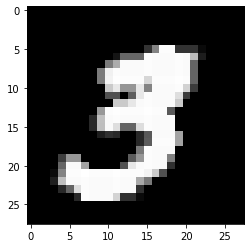

In [20]:
# 結果を見てみる
index = 209

model.eval() # 推論モードに切り替える
data = X_test[index]
output = model(data)
_,predicted = torch.max(output.data,0) # 確率が最大のラベルを求める

print("予測結果は{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("この画像データの正解ラベルは{:.0f}です".format(y_test[index]))